# การวิเคราะห์ทฤษฎีการซื้อเสียงในการเลือกตั้งไทย 2569

## การเลือกตั้งไทย 2569มีจุดที่น่าสงสัยตรงไหน?
- มีคนตั้งข้อสังเกตว่าพรรคเล็กๆที่คนไทย99%ไม่รู้จักด้วยซ้ำ กลับได้รับการโหวตพรรคการเมือง(บัตรเลือกตั้งสีชมพู)สูงผิดปกติ ซึ่งพรรคเหล่านั้นล้วนแล้วจับฉลากได้เลขพรรคตัวเดียวทั้งนั้น เช่น
  - เบอร์1 พรรคไทยทรัพย์ทวี
  - เบอร์2 พรรคเพื่อชาติไทย
  - เบอร์3 พรรคใหม่
  - เบอร์4 พรรคมิติใหม่
  - เบอร์5 พรรครวมใจไทย
  - เบอร์7 พรรคพลวัต
  - เบอร์8 พรรคประชาธิปไตยใหม่
- มี2ทฤษฎีที่สามารถอธิบายปรากฎการณ์นี้คือ
  1. ทฤษฎี Primary Effect: คนส่วนใหญ่ เวลาที่ไม่รู้จะเลือกอะไร มักจะเลือกตัวเลือกแรกๆไว้ก่อน ทำให้พรรคเบอร์ต้นๆมักจะได้รับคะแนนฟรีประมาณ1-2%จากผู้มาใช้สิทธิ
  2. ทฤษฎีซื้อเสียงแบบกาเบอร์เดียวกันทั้ง2ใบ  ← เราจะมาโฟกันกันที่ทฤษฎีนี้

## อะไรคือการซื้อเสียงแบบกาเบอร์เดียวกันทั้ง2ใบ?
การซื้อเสียงแบบให้ "กาเบอร์เดียวกันทั้ง2ใบ" เป็นเทคนิคทางสถิติที่หัวคะแนนหรือพรรคใหญ่ใช้เพื่อ "ตรวจสอบ" ว่าคนที่รับเงินไปนั้น กาคะแนนให้ตามที่ตกลงกันไว้จริงหรือไม่

เพื่อให้เห็นภาพชัดเจน จะสรุปขั้นตอนและเหตุผลที่เขาทำแบบนี้:
1. ระบบเลือกตั้งบัตร 2 ใบ:
    - ใบที่ 1 (สีเขียว): เลือก ส.ส. เขต (ตัวบุคคล)
    - ใบที่ 2 (สีชมพู): เลือก ส.ส. บัญชีรายชื่อ (พรรคการเมือง)

โดยปกติแล้ว เบอร์ของผู้สมัครเขตกับเบอร์ของพรรค **มักจะไม่ตรงกัน**

2. กลไกการ "ส่งสัญญาณ" (The Signal): 
สมมติว่าผู้สมัครพรรคใหญ่ในเขตนั้นได้ เบอร์ 3 เขาจะจ่ายเงินซื้อเสียงโดยสั่งกำชับว่า **"ให้กาเบอร์ 3 ทั้งสองใบนะ"**
    - ใบแรก: กาเบอร์ 3 เลือกเขา (ส.ส. เขต)
    - ใบที่สอง: กาเบอร์ 3 เลือกพรรคการเมือง (ซึ่งพรรคเบอร์ 3 อาจจะเป็นพรรคเล็กๆ ที่ไม่มีใครรู้จักเลย)

## ทำไมต้องทำแบบนี้? (ทำไมไม่ให้กาเบอร์พรรคตัวเอง?)
ถ้าพรรคใหญ่สั่งให้กาเบอร์พรรคตัวเองในใบที่ 2 เขาจะ ตรวจสอบไม่ได้ ว่าคะแนนมาจากคนที่เขาซื้อเสียงไปเท่าไหร่ เพราะพรรคใหญ่มีคะแนนนิยมตามธรรมชาติ (Organic Votes) ผสมอยู่เยอะจนแยกไม่ออก

แต่ถ้าให้ไปกา "พรรคเล็ก" ที่ไม่มีใครรู้จัก:
- ถ้าเขตนั้นมีคนกาพรรคเล็กเบอร์ 3 โผล่มา 5,000 คะแนน ทั้งๆ ที่พรรคนั้นไม่เคยหาเสียงเลย
- หัวคะแนนจะรู้ทันทีว่า "เงินที่จ่ายไปทำงานได้ผล" เพราะคะแนนนั้นเป็นคะแนนที่ถูก "สั่ง" ให้กาโดยเฉพาะ
- เป็นการยืนยันยอดเพื่อที่หัวคะแนนจะได้ไปเบิกเงินหรือรับค่าตอบแทนจากผู้สมัครได้ถูกต้อง

และอีก1เหตุผลที่สำคัญก็คือ **ป้องกันการกาผิดพลาด(จำเบอร์ไม่ได้ กาผิดเบอร์ กาสลับใบ)ในกลุ่มผู้สูงอายุ**


##### ข้อมูลเพิ่มเติม
1. [คลิปอธิบายผลการเลือกตั้งปี66ของอาจารย์ลอย](https://youtu.be/BJGsTKUcQYM)
2. [โพสต์ของ Khajochi's Blog](https://www.facebook.com/KhajochiBlog/posts/pfbid02fpYEPmdTYg8vZ4tRoKRmwvqjoFfm5k8CZ49Hm285ucTR1NgoGRUjpC5ZE4HLE2jl)

## เราจะมาพิสูจน์ซื้อเสียงแบบกาเบอร์เดียวกันทั้ง2ใบกัน
#### ทฤษฎี
ทฤษฎีนี้ตั้งสมมติฐานว่าในเขตที่มีการซื้อเสียงเกิดขึ้น:
1. ส.ส. เขต(MP)ที่ชนะคือผู้ที่ซื้อเสียง
2. ผู้ซื้อเสียงจะสั่งให้ผู้รับเงินเลือกพรรคการเมือง(PL) ที่มี **"หมายเลขเดียวกับเบอร์ของ ส.ส."** บนบัตรเลือกตั้งใบที่สอง(สีชมพู)

**สมมติฐาน:** หมายเลขของ ส.ส. ที่ชนะ จะต้องตรงกับหมายเลขของพรรคในบัญชีรายชื่อที่ติดอันดับ **TOP 7** ของเขตนั้นๆ แม้ว่าพรรคนั้นจะไม่ใช่พรรคต้นสังกัดของ ส.ส. ก็ตาม

*เหตุผลที่เลือกTOP7คือ พรรคใหญ่ที่คนเลือกอยู่แล้วมี4พรรค (ประชาชน เพื่อไทย ภูมิใจไทย ประชาธิปัตย์) + พรรคเล็กๆที่ได้อานิสงส์ในกรณี worst case ที่มี3พรรคซื้อเสียงในเขตเดียวกัน (🔴🔵🟢 ← สัญลักษณ์ไฟจราจรบนดาวอังคารของพรี่เต้ ไม่ได้สื่อถึงสีพรรคใดๆทั้งนั้น)

# *ย้ำตัวใหญ่ๆว่า เราใช้คำว่า"น่าสงสัย" ไม่ได้ไปตัดสินใครว่าซื้อหรือไม่ซื้อ

In [7]:
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font="Tahoma")

In [8]:
def analyze_vote_buying(mp_dir, pl_dir):
    results = []
    
    mp_files = glob.glob(os.path.join(mp_dir, "*.json"))
    
    for mp_file in mp_files:
        area_code = os.path.basename(mp_file).replace(".json", "")
        pl_file = os.path.join(pl_dir, f"{area_code}.json")
        
        if not os.path.exists(pl_file):
            continue
            
        with open(mp_file, 'r', encoding='utf-8') as f:
            mp_data = json.load(f)
            
        with open(pl_file, 'r', encoding='utf-8') as f:
            pl_data = json.load(f)
            
        # หาผู้ชนะ (rank 1)
        winner = next((entry for entry in mp_data['entries'] if entry['rank'] == 1), None)
        
        if winner:
            # หมายเลขผู้สมัคร (2 หลักสุดท้าย)
            candidate_code = winner['candidateCode']
            candidate_num = candidate_code[-2:]
            
            # หมายเลขพรรคที่ตรงกัน (สมมติว่าเป็น PARTY-00xx)
            target_party_id = f"PARTY-{candidate_num.zfill(4)}"
            
            # พรรคต้นสังกัดจริงของผู้ชนะ
            winner_party_id = winner['partyCode']
            
            # ดึง 7 อันดับแรกของคะแนนบัญชีรายชื่อ (Party List)
            top_pl = sorted(pl_data['entries'], key=lambda x: x['rank'])[:7]
            top_pl_codes = [p['partyCode'] for p in top_pl]
            
            # ตรวจสอบว่าพรรคเป้าหมายติด Top 7 หรือไม่
            is_in_top_7 = target_party_id in top_pl_codes
            
            # ตรวจสอบว่าพรรคเป้าหมายไม่ใช่พรรคเดียวกับผู้ชนะ
            is_cross_party = target_party_id != winner_party_id
            
            results.append({
                "area_code": area_code,
                "winner_candidate_num": candidate_num,
                "target_party_id": target_party_id,
                "winner_party_id": winner_party_id,
                "is_in_top_7": is_in_top_7,
                "is_cross_party": is_cross_party,
                "is_suspicious": is_in_top_7 and is_cross_party
            })
            
    return pd.DataFrame(results)

mp_dir = "../data/mp"
pl_dir = "../data/pl"

df = analyze_vote_buying(mp_dir, pl_dir)
suspicious_areas = df['is_suspicious'].sum()

## มีพรรคที่ได้รับอานิสงส์จากทฤษฎีนี้หรือไม่?
กราฟนี้แสดง 10 อันดับพรรคบัญชีรายชื่อที่ได้คะแนน **'ส้มหล่น'** บ่อยที่สุด โดยแยกสีตามพรรคของ ส.ส. เขตที่ชนะในพื้นที่นั้นๆ

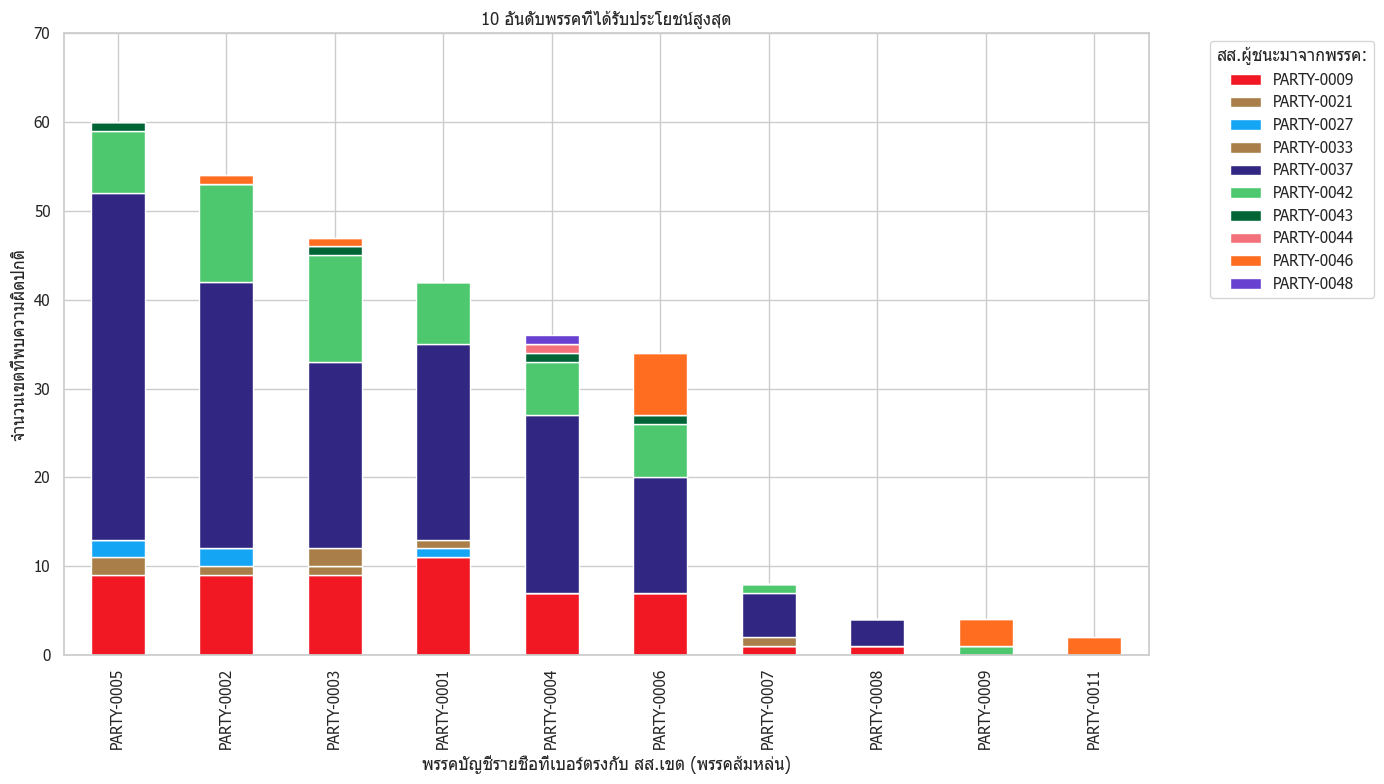

In [9]:
if suspicious_areas > 0:
    suspicious_df = df[df['is_suspicious']]
    
    # 10 อันดับพรรคบัญชีรายชื่อที่ได้ประโยชน์
    top_10_targets = suspicious_df['target_party_id'].value_counts().head(10).index
    plot_data = suspicious_df[suspicious_df['target_party_id'].isin(top_10_targets)]
    
    # สร้าง Pivot Table
    pivot_df = plot_data.groupby(['target_party_id', 'winner_party_id']).size().unstack(fill_value=0)
    
    # จัดเรียงตามจำนวนรวม
    pivot_df['total'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values('total', ascending=False).drop(columns='total')

    # กำหนดสีตามที่ระบุ
    color_map = {
        'PARTY-0009': '#f11824',
        'PARTY-0021': '#aa7e48',
        'PARTY-0027': '#15a5f5',
        'PARTY-0033': '#aa7e48',
        'PARTY-0037': '#312682',
        'PARTY-0042': '#4ec86f',
        'PARTY-0043': '#006536',
        'PARTY-0044': '#f2717a',
        'PARTY-0046': '#ff6d21',
        'PARTY-0048': '#6841d0'
    }

    # สร้างรายการสีสำหรับพรรคที่มีใน Pivot Table (ถ้าไม่มีใน map จะใช้สีเทา)
    colors = [color_map.get(col, '#cccccc') for col in pivot_df.columns]

    # พล็อต
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=colors)
    plt.title('10 อันดับพรรคที่ได้รับประโยชน์สูงสุด')
    plt.xlabel('พรรคบัญชีรายชื่อที่เบอร์ตรงกับ สส.เขต (พรรคส้มหล่น)')
    plt.ylabel('จำนวนเขตที่พบความผิดปกติ')
    plt.ylim(0, 70)
    plt.legend(title='สส.ผู้ชนะมาจากพรรค:', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("ไม่พบเขตที่มีความผิดปกติ")

#### *ข้อมูลเพิ่มเติม
พรรคเบอร์ 6กับเบอร์ 9ถือว่าเป็นพรรคใหญ่ที่มีคนเลือกเยอะอยู่แล้ว ข้อมูลในกราฟข้างบนของพรรคเหล่านี้อาจจะบอกอะไรเรามากไม่ได้

## พรรคส้มหล่นเหล่านี้ได้อันดับที่เท่าไหร่ในแต่ละเขต?

C:\Users\pasin\AppData\Local\Temp\ipykernel_9924\455161969.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rank_counts.index.astype(int), y=rank_counts.values, palette="viridis")


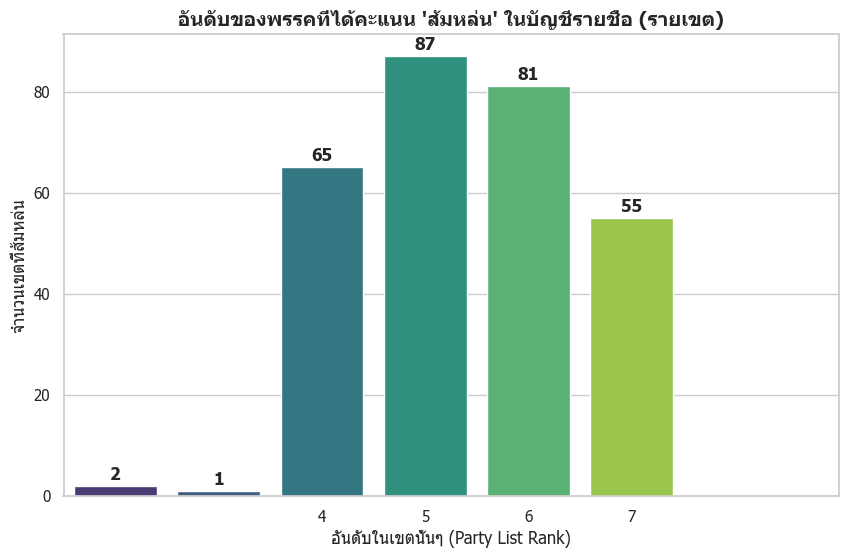

ตารางสรุปพรรคที่ได้รับการเอื้อประโยชน์ (Top 10)
pl_rank          2  3   4   5   6   7  total
target_party_id                             
PARTY-0005       0  0  18  14  17  11     60
PARTY-0002       0  0  22  25   5   2     54
PARTY-0003       0  0   2   7  23  15     47
PARTY-0001       0  0   7  14  13   8     42
PARTY-0004       0  0   2   9  11  14     36
PARTY-0006       0  0  13  14   6   1     34
PARTY-0007       0  0   0   3   3   2      8
PARTY-0008       0  0   0   0   2   2      4
PARTY-0009       2  1   1   0   0   0      4
PARTY-0011       0  0   0   1   1   0      2


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
import glob

print("Running Rank Distribution Analysis (Version 3.0)...")

# 1. Define target parties
target_party_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
target_party_ids = [f'PARTY-{str(n).zfill(4)}' for n in target_party_nums]
party_names = {
    'PARTY-0001': 'พรรคไทยทรัพย์ทวี (1)', 'PARTY-0002': 'พรรคเพื่อชาติไทย (2)', 
    'PARTY-0003': 'พรรคใหม่ (3)', 'PARTY-0004': 'พรรคมิติใหม่ (4)', 
    'PARTY-0005': 'พรรครวมใจไทย (5)', 'PARTY-0006': 'พรรคก้าวไกล (6)', 
    'PARTY-0007': 'พรรคพลวัต (7)', 'PARTY-0008': 'พรรคประชาธิปไตยใหม่ (8)', 
    'PARTY-0009': 'พรรคเพื่อไทย (9)', 'PARTY-0011': 'พรรคประชาชาติ (11)'
}

# 2. Prepare data
rank_data = []
pl_files = glob.glob("../data/pl/*.json")

if 'df' in locals():
    temp_df = df.copy()
else:
    # Fallback to function if df doesn't exist
    temp_df = analyze_vote_buying("../data/mp", "../data/pl")

temp_df['area_code_str'] = temp_df['area_code'].astype(str)
susp_map = temp_df.set_index('area_code_str')[['is_suspicious', 'target_party_id']].to_dict('index')

for f_path in pl_files:
    a_code = os.path.basename(f_path).replace(".json", "")
    with open(f_path, 'r', encoding='utf-8') as f_in:
        data = json.load(f_in)
    
    s_info = susp_map.get(a_code, {})
    is_susp_area = s_info.get('is_suspicious', False)
    t_party = s_info.get('target_party_id', "")
    
    for entry in data.get('entries', []):
        p_id = entry['partyCode']
        if p_id in target_party_ids:
            is_susp = is_susp_area and (p_id == t_party)
            rank_data.append({
                'party_id': p_id, 
                'rank': entry.get('rank', 99), 
                'is_suspicious': 'Suspicious' if is_susp else 'Normal'
            })

rank_df = pd.DataFrame(rank_data)

# 3. Plotting
if not rank_df.empty:
    sns.set_theme(style="whitegrid")
    for p_id in target_party_ids:
        p_name = party_names.get(p_id, p_id)
        p_sub = rank_df[rank_df['party_id'] == p_id]
        
        # Pivot for stacked bar
        # We use a fixed range of ranks (1-15)
        p_counts = p_sub.groupby(['rank', 'is_suspicious']).size().unstack(fill_value=0)
        
        # Ensure 'Normal' and 'Suspicious' columns exist
        for cat in ['Normal', 'Suspicious']:
            if cat not in p_counts.columns:
                p_counts[cat] = 0
        
        # Reindex to show 1-15
        p_counts = p_counts.reindex(range(1, 16), fill_value=0)
        
        plt.figure(figsize=(12, 4))
        plt.bar(p_counts.index, p_counts['Normal'], color='#bdc3c7', label='ปกติ')
        plt.bar(p_counts.index, p_counts['Suspicious'], bottom=p_counts['Normal'], color='#e74c3c', label='น่าสงสัย (เบอร์ตรงชนะ)')
        
        plt.title(f"การแจกแจงอันดับคะแนนพรรค: {p_name}", fontsize=16, fontweight='bold', family='Tahoma')
        plt.xlabel("อันดับของพรรคในเขต")
        plt.ylabel("จำนวนเขต")
        plt.xticks(range(1, 16))
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No rank data found.")


## ส.ส. ที่ชนะของแต่ละพรรค มีกี่คนที่น่าสงสัย?
วิเคราะห์ว่าในจำนวนเขตที่แต่ละพรรคชนะ มีกี่เปอร์เซ็นต์ที่เข้าข่ายทฤษฎีการซื้อเสียง

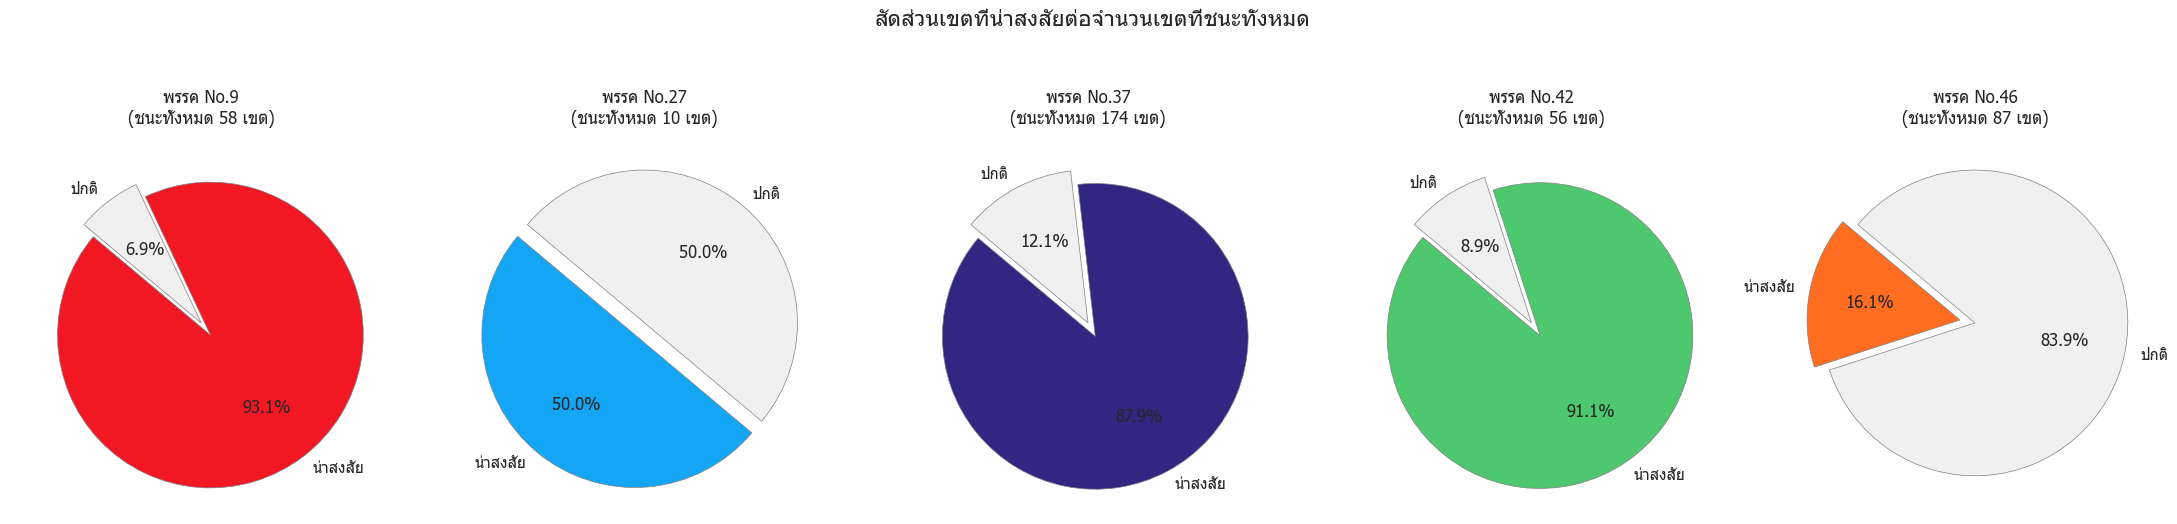

In [11]:
# รายชื่อพรรคที่ต้องการวิเคราะห์ (9, 27, 37, 42, 46)
target_winner_parties = ['PARTY-0009', 'PARTY-0027', 'PARTY-0037', 'PARTY-0042', 'PARTY-0046']

fig, axes = plt.subplots(1, 5, figsize=(22, 6))
fig.suptitle('สัดส่วนเขตที่น่าสงสัยต่อจำนวนเขตที่ชนะทั้งหมด', fontsize=16)

party_labels = {
    'PARTY-0009': 'พรรค No.9',
    'PARTY-0027': 'พรรค No.27',
    'PARTY-0037': 'พรรค No.37',
    'PARTY-0042': 'พรรค No.42',
    'PARTY-0046': 'พรรค No.46'
}

for i, party_id in enumerate(target_winner_parties):
    party_data = df[df['winner_party_id'] == party_id]
    total = len(party_data)
    suspicious = party_data['is_suspicious'].sum()
    normal = total - suspicious
    
    if total > 0:
        axes[i].pie([suspicious, normal], 
                    labels=['น่าสงสัย', 'ปกติ'], 
                    autopct='%1.1f%%', 
                    startangle=140, 
                    colors=[color_map.get(party_id, 'red'), '#f0f0f0'],
                    explode=(0.1, 0) if suspicious > 0 else (0, 0),
                    wedgeprops={'edgecolor': 'gray', 'linewidth': 0.5})
        axes[i].set_title(f"{party_labels[party_id]}\n(ชนะทั้งหมด {total} เขต)")
    else:
        axes[i].text(0.5, 0.5, 'ไม่มีข้อมูลการชนะ', ha='center', va='center')
        axes[i].set_title(f"{party_labels[party_id]}")
        axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## ส.ส. จากพรรคเหล่านี้เค้าจับได้เบอร์อะไรในเขตนั้นบ้าง?

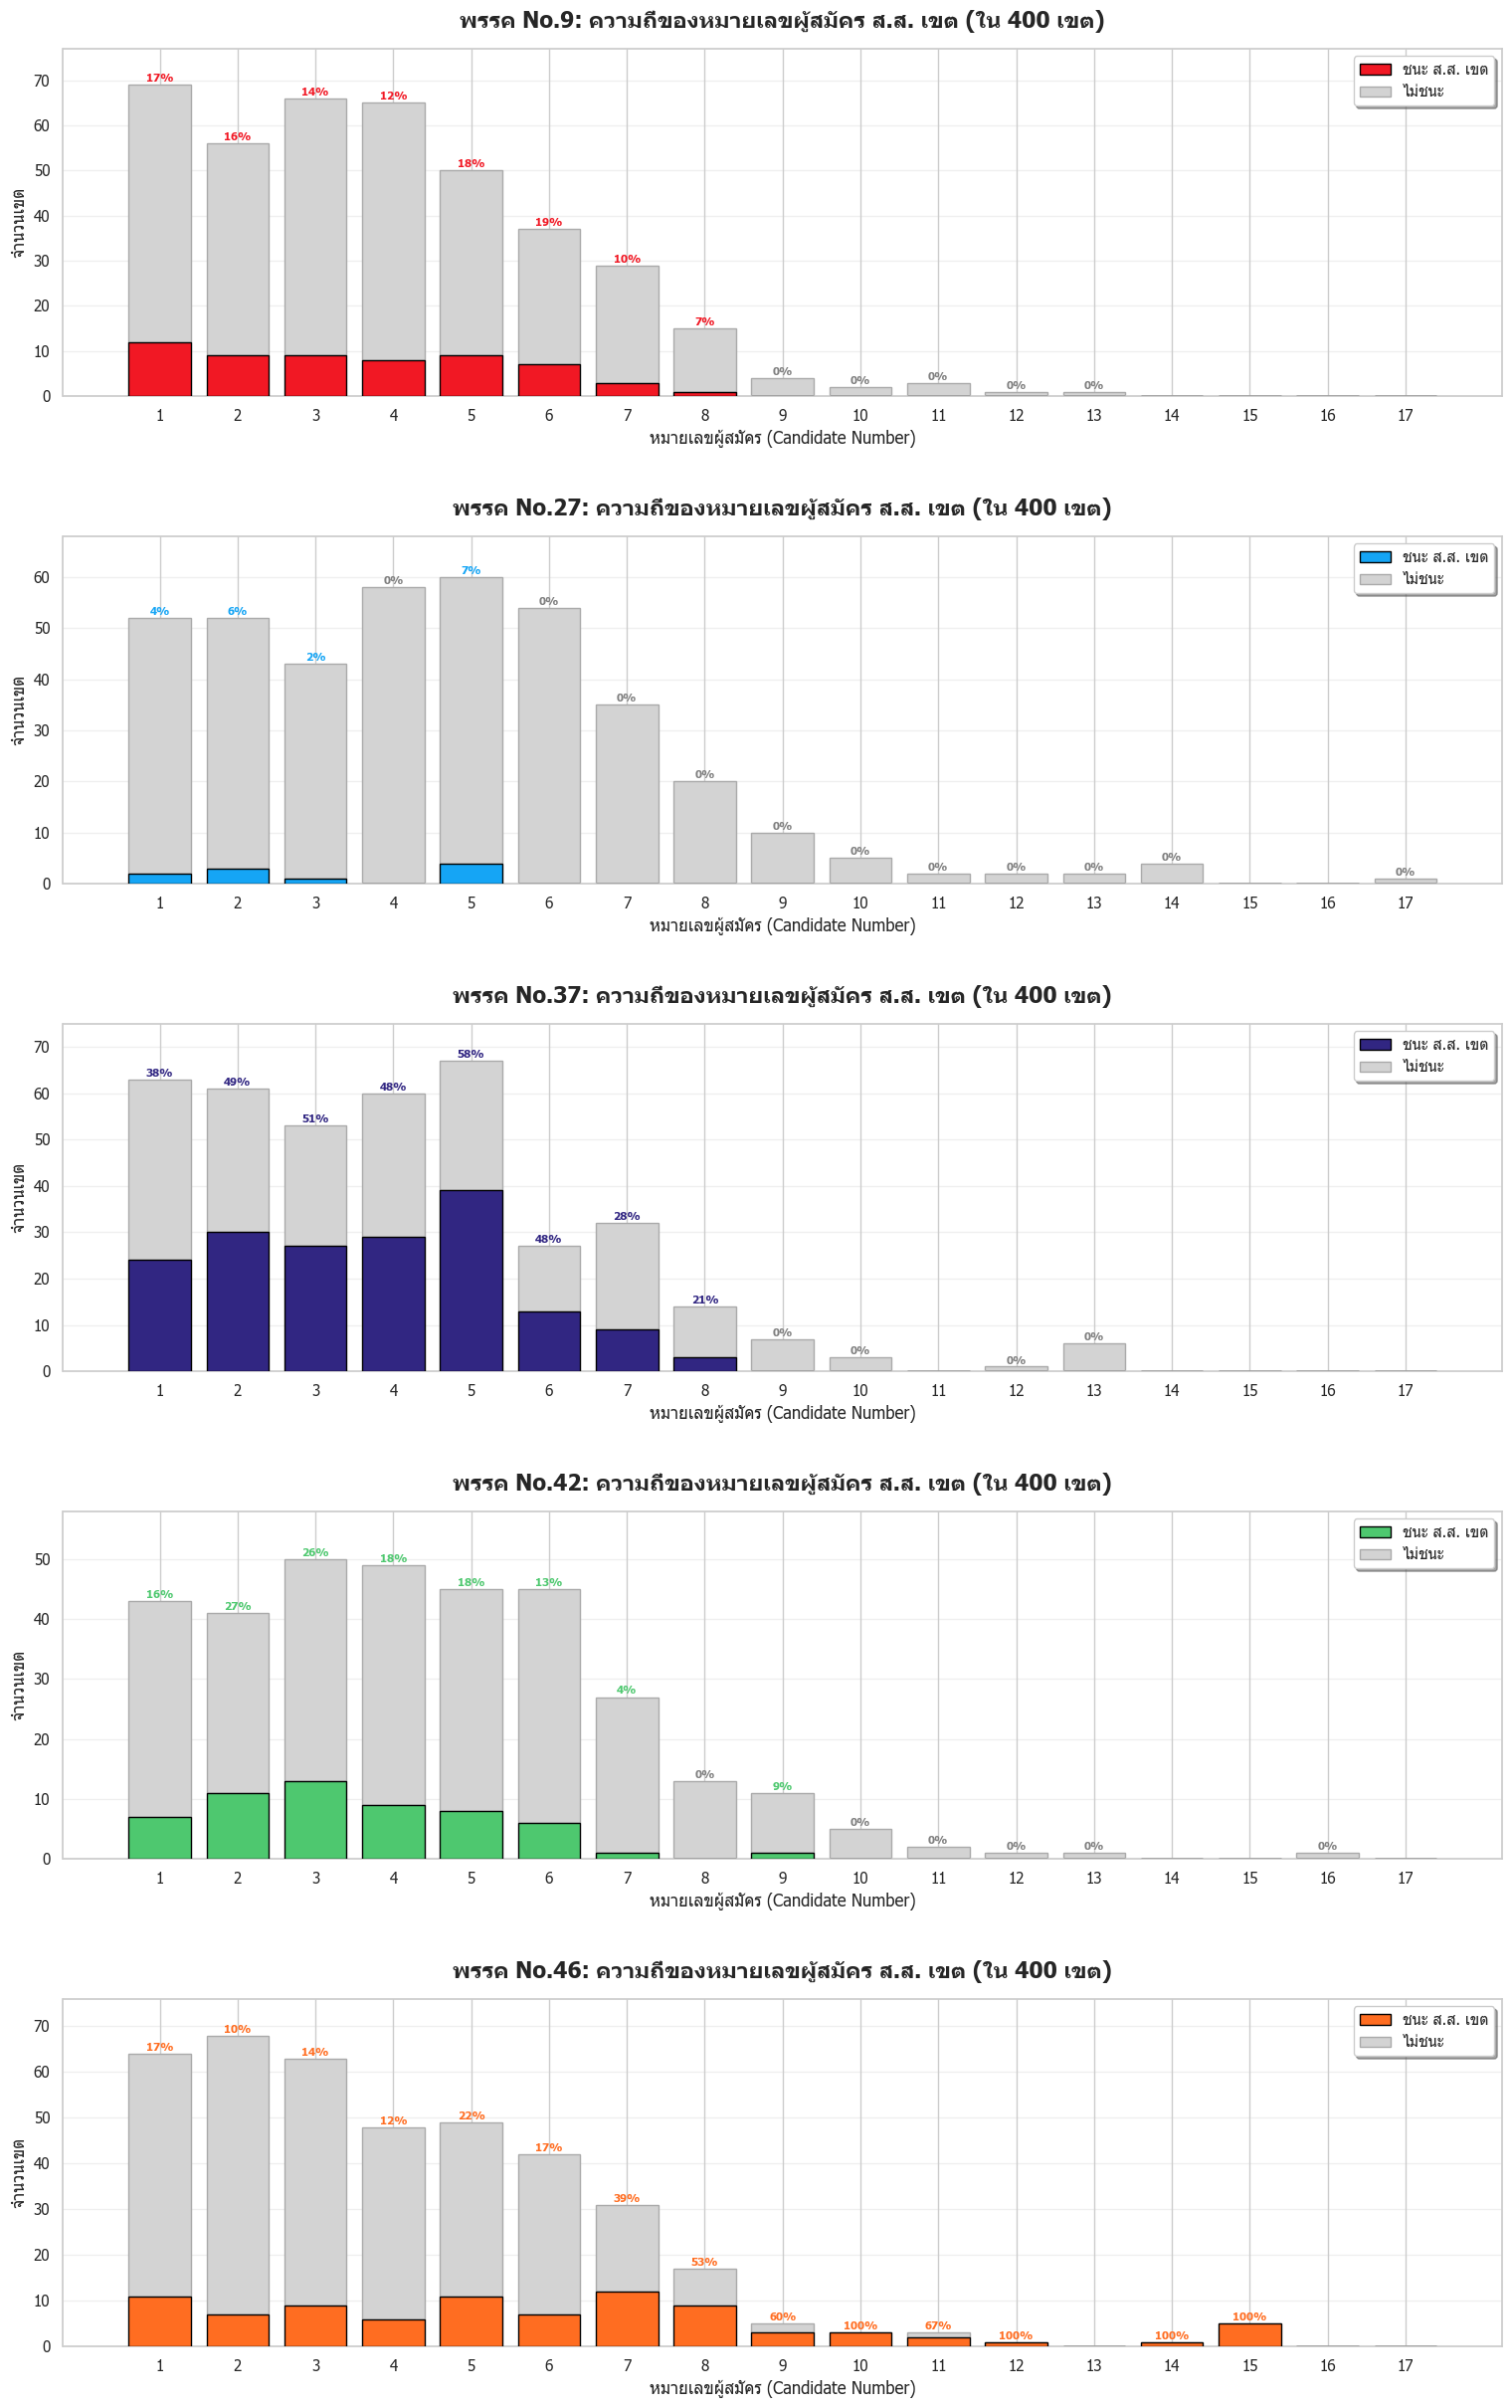

In [12]:
target_ids = ['PARTY-0009', 'PARTY-0027', 'PARTY-0037', 'PARTY-0042', 'PARTY-0046']

# 1. รวบรวมข้อมูลหมายเลขผู้สมัครของพรรคกลุ่มเป้าหมายในทุกเขต (400 เขต)
mp_numbers_list = []
mp_files = glob.glob(os.path.join(mp_dir, "*.json"))

for mp_file in mp_files:
    with open(mp_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    area_code = os.path.basename(mp_file).replace(".json", "")
    for entry in data['entries']:
        p_code = entry['partyCode']
        if p_code in target_ids:
            mp_numbers_list.append({
                'party_id': p_code,
                'number': int(entry['candidateCode'][-2:]),
                'won': entry['rank'] == 1
            })

mp_nums_total_df = pd.DataFrame(mp_numbers_list)

# 2. ข้อมูลพรรค (ชื่อและสี)
party_meta = {
    'PARTY-0009': {'name': 'No.9', 'color': '#f11824'},
    'PARTY-0027': {'name': 'No.27', 'color': '#15a5f5'},
    'PARTY-0037': {'name': 'No.37', 'color': '#312682'},
    'PARTY-0042': {'name': 'No.42', 'color': '#4ec86f'},
    'PARTY-0046': {'name': 'No.46', 'color': '#ff6d21'}
}

# 3. สร้างกราฟแยกตามพรรค
max_possible_num = mp_nums_total_df['number'].max() if not mp_nums_total_df.empty else 30
num_range = range(1, max_possible_num + 1)

n_parties = len(target_ids)
fig, axes = plt.subplots(n_parties, 1, figsize=(16, 5 * n_parties))
if n_parties == 1: axes = [axes]

for idx, party_id in enumerate(target_ids):
    ax = axes[idx]
    p_sub = mp_nums_total_df[mp_nums_total_df['party_id'] == party_id]
    
    if p_sub.empty:
        ax.text(0.5, 0.5, f"ไม่พบข้อมูลสำหรับ {party_id}", ha='center', va='center')
        continue
    
    # นับความถี่แยกตามเบอร์และผลลัพธ์ (ชนะ/ไม่ชนะ)
    win_data = p_sub[p_sub['won'] == True]['number'].value_counts().reindex(num_range, fill_value=0)
    loss_data = p_sub[p_sub['won'] == False]['number'].value_counts().reindex(num_range, fill_value=0)
    total_data = win_data + loss_data
    p_color = party_meta.get(party_id, {}).get('color', 'gray')
    p_name = party_meta.get(party_id, {}).get('name', party_id)
    
    # วาด Bar Chart แบบซ้อน (Stacked)
    ax.bar(num_range, win_data, color=p_color, edgecolor='black', label='ชนะ ส.ส. เขต', zorder=3)
    ax.bar(num_range, loss_data, bottom=win_data, color='lightgray', edgecolor='#aaaaaa', label='ไม่ชนะ', linewidth=1, zorder=2)
    
    # เพิ่มตัวเลขเปอร์เซ็นต์การชนะ
    for i in num_range:
        total = total_data[i]
        if total > 0:
            wins = win_data[i]
            perc = (wins / total) * 100
            # วางข้อความบนยอดกราฟ
            ax.text(i, total + 0.2, f"{perc:.0f}%", ha='center', va='bottom', fontsize=8, fontweight='bold', color=p_color if perc > 0 else 'gray')
    
    ax.set_title(f"พรรค {p_name}: ความถี่ของหมายเลขผู้สมัคร ส.ส. เขต (ใน 400 เขต)", fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel("หมายเลขผู้สมัคร (Candidate Number)", fontsize=12)
    ax.set_ylabel("จำนวนเขต", fontsize=12)
    ax.set_xticks(num_range)
    ax.set_ylim(0, max((total_data).max() + 8, 10))
    ax.legend(frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

## รายชื่อเขตที่พบความผิดปกติ แยกตามพรรค
แสดงรายชื่อเขตที่พรรค No.9, 27, 37, 42 และ 46 ชนะ และเข้าข่ายทฤษฎีการซื้อเสียง

In [13]:
# โหลดข้อมูลรหัสเขตและชื่อเขต
with open('../data/area_code/area_code.json', 'r', encoding='utf-8') as f:
    area_mapping_data = json.load(f)
area_name_map = {item['code']: item['name'] for item in area_mapping_data['areas']}

# รายชื่อพรรคที่ต้องการตรวจสอบ
target_ids = ['PARTY-0009', 'PARTY-0027', 'PARTY-0037', 'PARTY-0042', 'PARTY-0046']

print("เขตที่พบความผิดปกติ:\n")

for party_id in target_ids:
    label = party_labels.get(party_id, party_id)
    # กรองเฉพาะเขตที่พรรคนี้ชนะ และ is_suspicious เป็น True
    suspicious_list = df[(df['winner_party_id'] == party_id) & (df['is_suspicious'])]['area_code'].unique()
    
    if len(suspicious_list) > 0:
        print(f"{label} ({len(suspicious_list)} เขต):")
        # แสดงทั้งรหัสและชื่อเขต แบ่งกลุ่มบรรทัดละ 2 เขต
        formatted_list = [f"{area_name_map.get(code, 'ไม่พบชื่อเขต')}" for code in suspicious_list]
        # เรียงลำดับเพื่อให้ดูลำดับเขตง่ายขึ้น
        formatted_list = sorted(formatted_list, key=lambda x: x)

        for i in range(0, len(formatted_list), 2):
            print(f"  {'\n  '.join(formatted_list[i:i+2])}")
    else:
        print(f"{label}: ไม่พบเขตที่น่าสงสัย")
    print("-" * 30)

เขตที่พบความผิดปกติ:

พรรค No.9 (54 เขต):
  กาญจนบุรี เขต 1
  กาญจนบุรี เขต 5
  กาฬสินธุ์ เขต 1
  กาฬสินธุ์ เขต 2
  กาฬสินธุ์ เขต 4
  กาฬสินธุ์ เขต 6
  กำแพงเพชร เขต 3
  ขอนแก่น เขต 4
  ขอนแก่น เขต 7
  ขอนแก่น เขต 9
  ฉะเชิงเทรา เขต 1
  ชัยนาท เขต 1
  ชัยภูมิ เขต 1
  ชัยภูมิ เขต 2
  ชัยภูมิ เขต 5
  นครพนม เขต 2
  นครพนม เขต 4
  นครราชสีมา เขต 11
  นครราชสีมา เขต 12
  นครราชสีมา เขต 13
  นครราชสีมา เขต 15
  นครราชสีมา เขต 2
  นครราชสีมา เขต 4
  นครราชสีมา เขต 5
  นครราชสีมา เขต 6
  นครราชสีมา เขต 7
  นครราชสีมา เขต 8
  ปทุมธานี เขต 2
  มหาสารคาม เขต 5
  ร้อยเอ็ด เขต 5
  ร้อยเอ็ด เขต 6
  ร้อยเอ็ด เขต 8
  ลพบุรี เขต 4
  ศรีสะเกษ เขต 7
  สกลนคร เขต 3
  สกลนคร เขต 4
  สกลนคร เขต 7
  สุโขทัย เขต 1
  สุโขทัย เขต 2
  สุโขทัย เขต 3
  หนองบัวลำภู เขต 2
  อุดรธานี เขต 10
  อุดรธานี เขต 2
  อุดรธานี เขต 4
  อุดรธานี เขต 7
  อุดรธานี เขต 9
  อุตรดิตถ์ เขต 3
  อุบลราชธานี เขต 1
  อุบลราชธานี เขต 4
  อุบลราชธานี เขต 6
  เชียงราย เขต 2
  เลย เขต 1
  เลย เขต 2
  เลย เขต 4
------------------------------